# Import dependencies as setup notebook

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc, fbeta_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn
import time
import pickle
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

%matplotlib inline

Using TensorFlow backend.


## Helper functions

In [2]:
def plot_history(network_history,title='Loss and accuracy (Keras model)'):
    plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.subplot(212)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [3]:
def plot_roc(fpr, tpr, title):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

# Prepare features from generated data

In [4]:
data = pd.read_csv('../../machine_learning/cloud_functions/data-large.csv')
df = pd.DataFrame(data)
df=df.dropna(axis=0)
bins = 5
histogram_range = np.arange(bins)
series_features_list = ['temporal_gaussian-series',
                        'temporal_canny-series',
                        'temporal_cross_correlation-series',
                        'temporal_dct-series',
                        'temporal_difference-series',
                        'temporal_histogram_distance-series']
attack_IDs = []

#for column in df.columns:
#        if 'series' in column:    
#            for i in histogram_range:
#                df['{}-hist-{}'.format(column, i)] = 0.0
#                df['{}-mean-{}'.format(column, i)] = 0.0
         
for row_index, row in df.iterrows():
    dimension = int(row['attack'].split('_')[0].replace('p',''))

    if row['attack'] in ['1080p', '720p', '480p', '360p', '240p', '144p']:
            attack_IDs.append(1)
    else:
        attack_IDs.append(0)

    #for column in series_features_list:
    #    time_series = np.fromstring(row[column].replace('[','').replace(']',''), dtype=np.float, sep=' ')
    #    histogram = np.histogram(time_series, bins=histogram_range, density=True)[0]
    #    mean_series = np.array_split(time_series, bins)
    #    
    #    for i in np.arange(len(histogram)):
    #        df.at[row_index, '{}-hist-{}'.format(column, i)] = histogram[i]
    #        df.at[row_index, '{}-mean-{}'.format(column, i)] = mean_series[i].mean()
            
df['attack_ID'] = attack_IDs

In [5]:
df = df.drop(['Unnamed: 0',
              'attack',
              'title',
              'path',
              'kind',
              'temporal_gaussian-series',
             'temporal_canny-series',
             'temporal_cross_correlation-series',
             'temporal_difference-series',
             'temporal_histogram_distance-series', 
             'temporal_dct-series', 
        ],axis=1)
df=df.dropna(axis=0)
print('Number of attacks:',df[df['attack_ID']==0].shape)
print('Number of legit renditions:',df[df['attack_ID']==1].shape)

Number of attacks: (109976, 34)
Number of legit renditions: (18188, 34)


In [6]:
# Free memory
del data

# Data Visualization

In [7]:
df.head(125)

,dimension,fps,size,temporal_canny-euclidean,temporal_canny-manhattan,temporal_canny-max,temporal_canny-mean,temporal_canny-std,temporal_cross_correlation-euclidean,temporal_cross_correlation-manhattan,temporal_cross_correlation-max,temporal_cross_correlation-mean,temporal_cross_correlation-std,temporal_dct-euclidean,temporal_dct-manhattan,temporal_dct-max,temporal_dct-mean,temporal_dct-std,temporal_difference-euclidean,temporal_difference-manhattan,temporal_difference-max,temporal_difference-mean,temporal_difference-std,temporal_gaussian-euclidean,temporal_gaussian-manhattan,temporal_gaussian-max,temporal_gaussian-mean,temporal_gaussian-std,temporal_histogram_distance-euclidean,temporal_histogram_distance-manhattan,temporal_histogram_distance-max,temporal_histogram_distance-mean,temporal_histogram_distance-std,attack_ID
0,1080,29,5264133,7.167590,0.013203,0.130887,0.075101,0.022272,0.050605,2.112032,0.997725,0.995422,0.001143,35.444673,0.002651,3.979553,3.288968,0.327497,0.081874,4.081940,0.722792,0.606267,0.049689,16.522511,0.005776,1.984137,1.514054,0.285477,3.340637,0.028868,0.385370,0.309919,0.031505,0
1,1080,29,1194152,7.732898,0.012222,0.064453,0.022243,0.015266,0.010995,1.125966,0.999615,0.999027,0.000324,4.873064,0.020890,0.736389,0.424953,0.160961,0.439884,0.463156,0.898736,0.595829,0.068722,0.384700,0.398331,0.119650,0.030526,0.018843,0.366303,0.394302,0.062149,0.030749,0.014875,0
2,1080,29,5978909,5.940646,0.016015,0.274441,0.190754,0.021035,5.998315,0.015925,0.623170,0.445279,0.071778,465.186561,0.000201,48.228378,43.349308,1.601207,0.032775,1.327428,0.723090,0.612284,0.048098,2246.377257,0.000042,245.434283,208.458241,20.621722,0.046587,1.976843,0.006103,0.004297,0.000639,0
3,1080,29,5526314,7.290457,0.012975,0.117133,0.063544,0.020937,0.096844,26.073278,0.991337,0.990971,0.000167,140.295996,0.000667,15.382782,13.053813,0.868439,0.062225,1.705640,0.725071,0.611129,0.048088,118.810820,0.000788,13.807427,11.046699,0.847564,3.906239,0.024558,0.466188,0.362786,0.032724,0
4,1080,29,4815850,7.570566,0.012493,0.109890,0.037675,0.025444,0.097822,24.431297,0.993808,0.990948,0.001131,10.028362,0.009408,1.075564,0.932931,0.064381,0.062755,2.179239,0.727376,0.608700,0.047083,8.647905,0.010908,0.877652,0.805858,0.030146,0.236711,0.651023,0.024057,0.022053,0.000959,0
5,144,29,128627,7.826532,0.012072,0.070123,0.013418,0.010747,0.035328,1.568010,0.997962,0.996850,0.000964,6.531636,0.014962,1.037519,0.589863,0.151784,0.432024,0.563119,0.741618,0.603233,0.073824,1.063552,0.098332,0.195313,0.097127,0.020059,0.368645,0.349116,0.055327,0.033603,0.007249,1
6,144,29,144106,7.763968,0.012177,0.099257,0.019627,0.015888,0.079957,6.031550,0.995540,0.992746,0.001724,36.545058,0.002574,4.485832,3.386981,0.376510,0.487738,0.439931,0.741455,0.597782,0.078238,17.030802,0.005592,2.179516,1.563719,0.277385,3.351312,0.028769,0.387685,0.310950,0.031202,0
7,144,29,36763,7.823021,0.012080,0.074761,0.013847,0.011407,0.099502,159.997864,0.994674,0.991250,0.003087,11.856751,0.008234,2.209846,1.064820,0.297684,1.920128,0.063668,0.866428,0.494936,0.166658,3.902221,0.027805,0.816601,0.321435,0.170562,1.316163,0.080847,0.200074,0.116252,0.039354,0
8,144,29,153315,6.209201,0.015289,0.244656,0.164952,0.016829,5.917802,0.016149,0.630108,0.452845,0.071742,458.401405,0.000204,47.418232,42.716138,1.601559,0.439507,0.497833,0.747206,0.609469,0.075831,2219.348270,0.000042,243.002470,205.927163,20.603326,0.481177,0.245913,0.066154,0.044056,0.008506,0
9,144,29,142237,7.817495,0.012086,0.064535,0.014213,0.010164,0.133683,2.332032,0.989161,0.987576,0.001018,141.154432,0.000663,15.712341,13.128998,0.941583,0.434637,0.472494,0.736627,0.603941,0.076141,123.418804,0.000758,14.581217,11.475533,0.875255,4.110569,0.023317,0.515025,0.381627,0.035906,0


In [8]:
df.describe()

,dimension,fps,size,temporal_canny-euclidean,temporal_canny-manhattan,temporal_canny-max,temporal_canny-mean,temporal_canny-std,temporal_cross_correlation-euclidean,temporal_cross_correlation-manhattan,temporal_cross_correlation-max,temporal_cross_correlation-mean,temporal_cross_correlation-std,temporal_dct-euclidean,temporal_dct-manhattan,temporal_dct-max,temporal_dct-mean,temporal_dct-std,temporal_difference-euclidean,temporal_difference-manhattan,temporal_difference-max,temporal_difference-mean,temporal_difference-std,temporal_gaussian-euclidean,temporal_gaussian-manhattan,temporal_gaussian-max,temporal_gaussian-mean,temporal_gaussian-std,temporal_histogram_distance-euclidean,temporal_histogram_distance-manhattan,temporal_histogram_distance-max,temporal_histogram_distance-mean,temporal_histogram_distance-std,attack_ID
count,128164.000000,128164.000000,1.281640e+05,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,1.281640e+05,1.281640e+05,1.281640e+05,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,1.281640e+05,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000,128164.000000
mean,488.098249,27.251381,1.204445e+06,6.104703,0.025317,0.359282,0.155615,0.067367,0.635387,4.719248,9.567054e-01,9.405972e-01,1.141822e-02,108.815431,0.027417,13.137334,10.264490,1.444752,0.777075,2.534723,0.791253,0.485007,0.129958,246.157915,2.241124,31.332466,22.917582,4.201739e+00,3.872877,2.873192,0.479476,0.363224,0.057254,0.141912
std,305.238447,2.900264,1.589007e+06,2.364619,0.106873,0.264048,0.184807,0.066094,1.290378,146.403373,9.802616e-02,1.221832e-01,3.390740e-02,132.650803,0.691277,15.773946,12.534265,2.754922,0.620272,122.026719,0.223678,0.247889,0.078283,471.323312,241.474213,59.153648,44.074073,1.095049e+01,6.483123,94.929898,0.755000,0.614150,0.120390,0.348961
min,144.000000,6.000000,7.787000e+03,0.000000,0.008475,0.000000,0.000000,0.000000,0.000002,0.008842,5.157279e-09,-2.864360e-10,1.981512e-09,0.019794,0.000091,0.004785,0.001034,0.000058,0.000499,0.015405,0.000000,0.000000,0.000000,0.000099,0.000018,0.000012,0.000003,1.783229e-07,0.000000,0.001950,0.000000,0.000000,0.000000,0.000000
25%,240.000000,25.000000,1.974452e+05,4.309674,0.012357,0.131205,0.033351,0.022383,0.028904,0.467382,9.773392e-01,9.709961e-01,3.664600e-04,5.457741,0.000512,0.920010,0.496267,0.077188,0.341747,0.139624,0.675178,0.287911,0.071483,1.228988,0.000361,0.241274,0.105575,2.574518e-02,0.180141,0.020668,0.028709,0.016370,0.003170,0.000000
50%,360.000000,29.000000,5.992225e+05,6.238710,0.016282,0.286485,0.079587,0.042772,0.118983,1.071827,9.939226e-01,9.891447e-01,1.281614e-03,35.750523,0.002910,4.772163,3.301354,0.266273,0.619012,0.277280,0.876194,0.505203,0.110358,19.617431,0.005146,2.516917,1.824228,2.334562e-01,0.561484,0.219609,0.087820,0.051278,0.010826,0.000000
75%,720.000000,29.000000,1.456755e+06,7.968533,0.024596,0.557210,0.206399,0.088376,0.313516,1.634118,9.988238e-01,9.973794e-01,5.004154e-03,194.372526,0.019110,23.165755,18.323567,1.479433,1.029417,0.672495,0.975023,0.686402,0.172512,277.090751,0.096414,34.238799,25.827576,2.577890e+00,5.043199,1.134605,0.659310,0.463683,0.046385,0.000000
max,1080.000000,30.000000,2.179615e+07,10.907700,30.166939,0.999973,0.993631,0.423433,10.647140,36954.220264,1.000000e+00,9.999998e-01,4.759197e-01,1125.423974,168.983933,128.047729,117.543450,35.916753,6.477404,36863.999999,1.000000,0.971228,0.466529,5294.496925,63744.906345,594.678739,493.714384,1.515922e+02,48.556617,27421.272173,6.166994,4.468461,2.235468,1.000000


# Define input data

We choose the input of our models (we try to make balanced dataset)

In [9]:
# Define training set as 80% of total specimens
num_train = int(df.shape[0]*0.8)

df_train_all = df[0:num_train]
df_test_all = df[num_train:]
print('We have {} train specimens and {} test specimens'.format(len(df_train_all), len(df_test_all)))

# Balance the training dataset by limiting the number of negative specimens to resemble what we have of positive
df_train_1 = df_train_all[df_train_all['attack_ID'] == 1]
df_train_0 = df_train_all[df_train_all['attack_ID'] == 0]

print('We have {} positive training specimens and {} negative training specimens'.format(len(df_train_1), len(df_train_0)))
# Take a sample from the training positives and build the final training set
df_sample_train = df_train_0.sample(df_train_1.shape[0])
df_train = df_train_1.append(df_sample_train)
df_train = df_train.sample(frac=1)
print('Balanced training set established with shape {}'.format(df_train.shape))
print('We have {} positive training specimens and {} negative training specimens'.format(len(df_train_1), len(df_sample_train)))

X_test_all = df_test_all.drop(['attack_ID'],axis=1)
df_test_1 = df_test_all[df_test_all['attack_ID'] == 1]
df_test_0 = df_test_all[df_test_all['attack_ID'] == 0]

print('We have {} positive testing specimens and {} negative testing specimens'.format(len(df_test_1), len(df_test_0)))
# Get another sample from the testing positives and build the final test set
df_sample_test = df_test_0.sample(df_test_0.shape[0])
df_test = df_test_1.append(df_sample_test)
df_test = df_test.sample(frac=0.4)
print('Balanced test set established with shape {}'.format(df_test.shape))

X_test_all = np.asarray(X_test_all)

y_test_all = df_test_all['attack_ID']
y_test_all = np.asarray(y_test_all)

X_train = df_train.drop(['attack_ID'],axis=1)
X_train = np.asarray(X_train)

X_test = df_test.drop(['attack_ID'],axis=1)
X_test = np.asarray(X_test)

y_train = df_train['attack_ID']
y_train = np.asarray(y_train)

y_test = df_test['attack_ID']
y_test = np.asarray(y_test)

We have 102531 train specimens and 25633 test specimens
We have 14550 positive training specimens and 87981 negative training specimens
Balanced training set established with shape (29100, 34)
We have 14550 positive training specimens and 14550 negative training specimens
We have 3638 positive testing specimens and 21995 negative testing specimens
Balanced test set established with shape (10253, 34)


First we define a model where we take all variables :

In [10]:
print('TRAIN:', X_train.shape)
print('TEST:', X_test.shape)
print(df_train.columns)

TRAIN: (29100, 33)
TEST: (10253, 33)
Index(['dimension', 'fps', 'size', 'temporal_canny-euclidean',
       'temporal_canny-manhattan', 'temporal_canny-max', 'temporal_canny-mean',
       'temporal_canny-std', 'temporal_cross_correlation-euclidean',
       'temporal_cross_correlation-manhattan',
       'temporal_cross_correlation-max', 'temporal_cross_correlation-mean',
       'temporal_cross_correlation-std', 'temporal_dct-euclidean',
       'temporal_dct-manhattan', 'temporal_dct-max', 'temporal_dct-mean',
       'temporal_dct-std', 'temporal_difference-euclidean',
       'temporal_difference-manhattan', 'temporal_difference-max',
       'temporal_difference-mean', 'temporal_difference-std',
       'temporal_gaussian-euclidean', 'temporal_gaussian-manhattan',
       'temporal_gaussian-max', 'temporal_gaussian-mean',
       'temporal_gaussian-std', 'temporal_histogram_distance-euclidean',
       'temporal_histogram_distance-manhattan',
       'temporal_histogram_distance-max', 'tempora

Then we can normalize input data to facilitate model convergence

In [11]:
MinMax_scaler = MinMaxScaler()
Standard_scaler = StandardScaler()

X_train_scaled_MinMax = MinMax_scaler.fit_transform(X_train) 
X_test_scaled_MinMax = MinMax_scaler.transform(X_test) 
X_test_scaled_MinMax_all = MinMax_scaler.transform(X_test_all) 

X_train_scaled_standard = Standard_scaler.fit_transform(X_train)
X_test_scaled_standard = Standard_scaler.transform(X_test)
X_test_scaled_standard_all = Standard_scaler.transform(X_test_all)

# Define models
We will explore results with different ML techniques

## Keras neural network

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)  

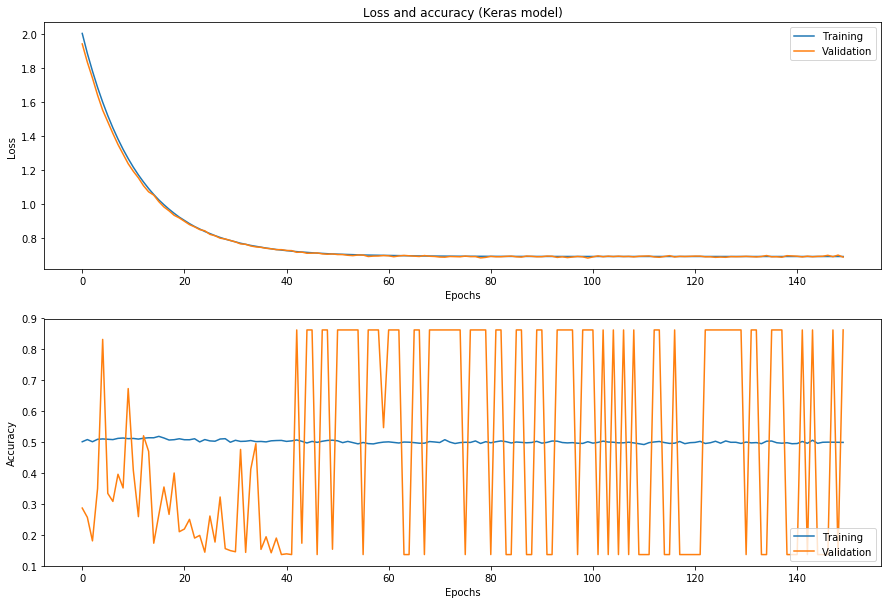

In [12]:
def model():
    model = Sequential()
    
    model.add(Dense(128, input_shape=(X_train.shape[1],), activation= "relu", kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.1))
    
    model.add(Dense(64, activation= "relu", kernel_regularizer=l2(0.01)))    
    model.add(Dropout(0.2))
    
    model.add(Dense(128, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model.add(Dropout(0.4))
    
    model.add(Dense(64, kernel_initializer='glorot_uniform', activation= "tanh"))
    model.add(Dropout(0.5))
    
    model.add(Dense(32, kernel_initializer='glorot_uniform', activation= "tanh"))
    model.add(Dropout(0.4))
    
    model.add(Dense(128, kernel_initializer='glorot_uniform', activation= "tanh"))
    model.add(Dropout(0.3))
    
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.summary()
    network_history = model.fit(X_train_scaled_standard, y_train, batch_size=128, epochs=150, verbose=0, validation_data=(X_test_scaled_standard,y_test))
    plot_history(network_history)
    return model

NN_model = model()


# Save the weights
NN_model.save_weights('../output/models/NN_model_weights.h5')

# Save the model architecture
with open('../output/models/model_architecture.json', 'w') as f:
    f.write(NN_model.to_json())

In [13]:
print(NN_model.metrics_names)
NN_model.evaluate(X_test_scaled_standard, y_test)

['loss', 'acc']
10253/10253 [==============================] - 0s 14us/step


[0.689784619397307, 0.862284209505472]

In [14]:
y_pred = NN_model.predict(X_test_scaled_standard)

In [15]:
rounded = [round(x[0]) for x in y_pred]
y_pred_bin = np.array(rounded, dtype='int64')
confusion_matrix(y_test, y_pred_bin)

array([[8841,    0],
       [1412,    0]])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


TNR=0.0, TPR=1.0, F20=0.0


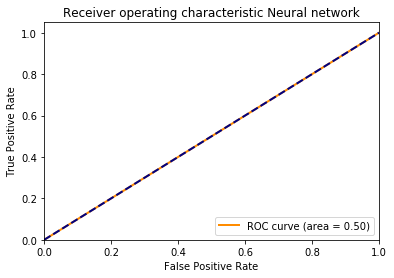

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_pred_bin)
fb = fbeta_score(y_test, y_pred_bin, beta=20, pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'Neural network')

# Random forest with scikit-learn

In [17]:
X_train_RF = X_train_scaled_MinMax
X_test_RF = X_test_scaled_MinMax

random_forest = RandomForestClassifier(n_estimators=150, random_state=12)
random_forest.fit(X_train_RF, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [18]:
random_forest.score(X_test_RF, y_test)

0.9684970252608992

In [19]:
prediction_RF = random_forest.predict(X_test_RF)

In [20]:
confusion_matrix(y_test, prediction_RF)

array([[8539,  302],
       [  21, 1391]])

TNR=0.9658409682162651, TPR=0.9851274787535411, F20=0.9846388216624037


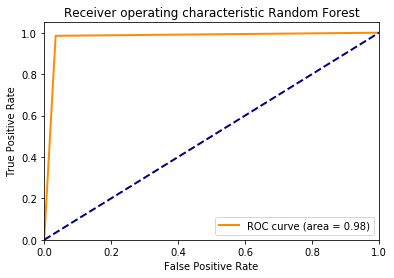

In [21]:
fpr, tpr, _ = roc_curve(y_test, prediction_RF)
fb = fbeta_score(y_test, prediction_RF, beta=20, pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'Random Forest')

### Export model to use in CLI

In [22]:
# save model to file
pickle.dump(random_forest, open("../output/models/random_forest.pickle.dat", "wb"))

# AdaBoost with scikit-learn

In [23]:
X_train_AB = X_train_scaled_MinMax
X_test_AB = X_test_scaled_MinMax

AdaBoost = AdaBoostClassifier(learning_rate=0.55, random_state=3)
AdaBoost.fit(X_train_AB, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.55, n_estimators=50, random_state=3)

In [24]:
AdaBoost.score(X_test_AB, y_test)

0.9473324880522774

In [25]:
prediction_AdaBoost = AdaBoost.predict(X_test_AB)

In [26]:
confusion_matrix(y_test, prediction_AdaBoost)

array([[8327,  514],
       [  26, 1386]])

TNR=0.9418617803415903, TPR=0.9815864022662889, F20=0.9807411328745367


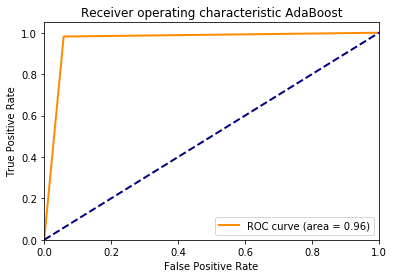

In [27]:
fpr, tpr, _ = roc_curve(y_test, prediction_AdaBoost)
fb = fbeta_score(y_test, prediction_AdaBoost, beta=20,pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'AdaBoost')

In [28]:
print(AdaBoost)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.55, n_estimators=50, random_state=3)


### Export model to use in CLI

In [29]:
# save model to file
pickle.dump(AdaBoost, open("../output/models/AdaBoost.pickle.dat", "wb"))

# SVM with scikit-learn

In [30]:
X_train_SVM = X_train_scaled_MinMax
X_test_SVM = X_test_scaled_MinMax_all
Y_test_SVM = y_test_all

classifier = svm.SVC(kernel='rbf')
classifier.fit(X_train_SVM, y_train)
prediction_SVM = classifier.predict(X_test_SVM)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [31]:
classifier.score(X_test_SVM,Y_test_SVM)

0.7370576990598057

In [32]:
confusion_matrix(Y_test_SVM, prediction_SVM)

array([[15290,  6705],
       [   35,  3603]])

TNR=0.6951579904523755, TPR=0.9903793293018142, F20=0.9858717932621315


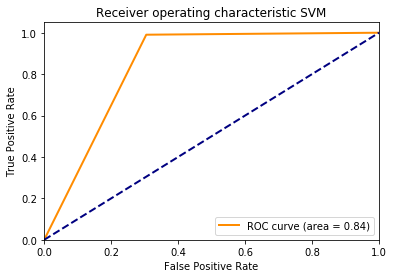

In [33]:
fpr, tpr, _ = roc_curve(Y_test_SVM, prediction_SVM)
fb = fbeta_score(Y_test_SVM, prediction_SVM, beta=20, pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'SVM')

# XGBoost

In [34]:
X_train_XGB = X_train
X_test_XGB = X_test_all
Y_test_XGB = y_test_all

XGBoost = xgb.XGBClassifier()
grid = {'max_depth':10}
XGBoost.set_params(**grid)
XGBoost.fit(X_train_XGB, y_train)
prediction_XGB = XGBoost.predict(X_test_XGB)

In [35]:
XGBoost.score(X_test_XGB,Y_test_XGB)

0.9795966137401007

In [36]:
confusion_matrix(Y_test_XGB, prediction_XGB)

array([[21535,   460],
       [   63,  3575]])

TNR=0.9790861559445329, TPR=0.9826827927432655, F20=0.9824154437085185


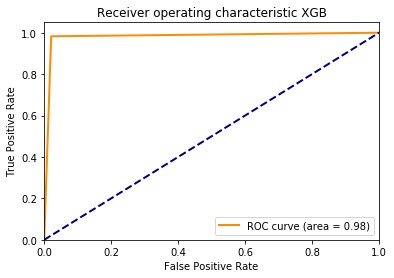

In [37]:
fpr, tpr, _ = roc_curve(Y_test_XGB, prediction_XGB)
fb = fbeta_score(y_test_all, prediction_XGB, beta=20, pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'XGB')

### Export model to use in CLI

In [38]:
# save model to file
pickle.dump(XGBoost, open("../output/models/XGBoost.pickle.dat", "wb"))